# ROI Summary by Slide and Group - Optimized Version

**Optimizations Applied:**
- Eliminated redundant data loading logic with clear conditional flow
- Vectorized operations and reduced repeated DataFrame operations
- Consolidated plotting logic with reusable functions
- Improved memory efficiency by avoiding unnecessary copies
- Enhanced error handling and validation
- Reduced code duplication across visualization cells
- Better variable naming and code organization

Set `RESULTS_FOLDER` to the folder containing `*_roi_summary.csv` and `*_roi_details.csv` files and run cells in order.

In [1]:
# 1) Imports and Configuration
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

sns.set_style('white')

# Configuration
RESULTS_FOLDER = Path(r"S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results")
EXCLUDED_SLIDES = {15}  # Slides to exclude from analysis
DPI = 600  # Output figure resolution

print(f"Looking for results in: {RESULTS_FOLDER}")

Looking for results in: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results


In [2]:
# 2) Helper Functions
def slide_to_group(slide):
    """Map slide number to group name with LaTeX formatting for superscripts."""
    if pd.isna(slide):
        return 'Unknown'
    slide = int(slide)
    if slide in (1, 2, 3, 4):
        return 'WT-Saline'
    if slide in (5, 6, 7, 8):
        return r'HSA$^{\mathrm{LR}}$-Saline'
    if slide in (9, 10, 11, 12, 13):
        return r'HSA$^{\mathrm{LR}}$-CLAAAV'
    return 'Unknown'


def parse_base_to_parts(base_str):
    """Parse image base string to extract slide/region/subregion information."""
    parts = re.split('[_\-]', base_str)
    nums = [p for p in parts if p.isdigit()]
    nums.extend([None] * (4 - len(nums)))  # Pad to length 4
    
    return {
        'orig': base_str,
        'part0': parts[0] if parts else None,
        'slide': int(nums[1]) if nums[1] is not None else None,
        'region': int(nums[2]) if nums[2] is not None else None,
        'subregion': int(nums[3]) if nums[3] is not None else None
    }


def load_csv_files(folder, pattern, aggregated_name=None):
    """Load CSV files from folder, preferring aggregated file if available."""
    if aggregated_name:
        agg_path = folder / aggregated_name
        if agg_path.exists():
            df = pd.read_csv(agg_path)
            print(f"✓ Loaded aggregated: {aggregated_name} ({len(df)} rows)")
            return df
    
    files = sorted(folder.glob(pattern))
    if not files:
        return None
    
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    print(f"✓ Loaded {len(files)} files matching '{pattern}' ({len(df)} rows)")
    return df


def enhance_dataframe(df, excluded_slides=None):
    """Add parsed fields and group mappings to dataframe."""
    if df is None:
        return None
    
    # Identify base column
    base_col = 'image_base' if 'image_base' in df.columns else next((c for c in df.columns if 'base' in c), None)
    if not base_col:
        raise ValueError("No 'base' or 'image_base' column found")
    
    df['base'] = df[base_col]
    
    # Parse and add fields
    parsed = df['base'].apply(parse_base_to_parts).apply(pd.Series)
    df = pd.concat([df, parsed], axis=1)
    df['group'] = df['slide'].apply(slide_to_group)
    
    # Filter excluded slides
    if excluded_slides:
        original_len = len(df)
        df = df[~df['slide'].isin(excluded_slides)]
        if len(df) < original_len:
            print(f"  → Filtered out slides {excluded_slides}: {original_len} → {len(df)} rows")
    
    return df


def style_axis(ax, hide_top_right=True, spine_width=2):
    """Apply consistent styling to axis."""
    if hide_top_right:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    ax.spines['left'].set_linewidth(spine_width)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(spine_width)
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='y', labelsize=12, width=spine_width)
    ax.grid(False)

In [3]:
# 3) Load and Process Data
# Load summary data
summary_df = load_csv_files(RESULTS_FOLDER, '*_roi_summary.csv', 'all_roi_summary_0204.csv')
if summary_df is None:
    raise FileNotFoundError(f"No summary CSV files found in {RESULTS_FOLDER}")

# Load details data (optional, for internal nuclei count)
details_df = load_csv_files(RESULTS_FOLDER, '*_roi_details.csv', 'all_roi_details_0204.csv')
if details_df is None:
    print("⚠ No details files found; will use summary data only for internal counts")

# Enhance both dataframes
summary_df = enhance_dataframe(summary_df, EXCLUDED_SLIDES)
details_df = enhance_dataframe(details_df, EXCLUDED_SLIDES)

print(f"\n✓ Data loaded: {len(summary_df)} summary records")
summary_df.head()

✓ Loaded aggregated: all_roi_summary_0204.csv (78 rows)
✓ Loaded aggregated: all_roi_details_0204.csv (4042 rows)
  → Filtered out slides {15}: 78 → 75 rows
  → Filtered out slides {15}: 4042 → 3835 rows

✓ Data loaded: 75 summary records


,image_base,orig_num_cells,removed_small_cells,num_cells,num_rois,n_internal,n_edge,n_outside,base,orig,part0,slide,region,subregion,group
0,01_01_02_0,77,2,77,32,0,27,5,01_01_02_0,01_01_02_0,01,1,2,0,WT-Saline
1,01_01_02_1,96,11,92,56,0,55,1,01_01_02_1,01_01_02_1,01,1,2,1,WT-Saline
2,01_01_03_0,50,0,50,25,0,25,0,01_01_03_0,01_01_03_0,01,1,3,0,WT-Saline
3,01_01_03_1,53,2,52,21,1,18,2,01_01_03_1,01_01_03_1,01,1,3,1,WT-Saline
4,01_01_04_0,53,0,53,22,0,22,0,01_01_04_0,01_01_04_0,01,1,4,0,WT-Saline


In [4]:
# 4) Calculate Internal Nuclei and Ensure Required Columns
# Compute n_internal from details if not present in summary
if 'n_internal' not in summary_df.columns and details_df is not None:
    internal_counts = (details_df[details_df['classification'] == 'internal']
                       .groupby('base').size().rename('n_internal'))
    summary_df = summary_df.merge(internal_counts, how='left', left_on='base', right_index=True)

# Ensure all required numeric columns exist
for col in ['num_cells', 'num_rois', 'n_internal']:
    if col not in summary_df.columns:
        summary_df[col] = 0
    else:
        summary_df[col] = summary_df[col].fillna(0).astype(int)

print(f"✓ Data validation complete. Columns: {list(summary_df.columns)}")

✓ Data validation complete. Columns: ['image_base', 'orig_num_cells', 'removed_small_cells', 'num_cells', 'num_rois', 'n_internal', 'n_edge', 'n_outside', 'base', 'orig', 'part0', 'slide', 'region', 'subregion', 'group']


In [5]:
# 5) Aggregate by Slide and Group
# Per-slide aggregation
slide_agg = (summary_df.groupby('slide', as_index=False)
             .agg(slides_count=('base', 'nunique'),
                  total_cells=('num_cells', 'sum'),
                  total_rois=('num_rois', 'sum'),
                  total_internal=('n_internal', 'sum')))

slide_agg['group'] = slide_agg['slide'].apply(slide_to_group)

# Calculate ratios
slide_agg['internal_ratio_pct'] = (slide_agg['total_internal'] / slide_agg['total_rois'] * 100).fillna(0)
slide_agg['nuclei_per_cell'] = (slide_agg['total_rois'] / slide_agg['total_cells']).fillna(0)

# Per-group aggregation
group_agg = (slide_agg.groupby('group', as_index=False)
             .agg(slides_count=('slide', 'nunique'),
                  total_cells=('total_cells', 'sum'),
                  total_rois=('total_rois', 'sum'),
                  total_internal=('total_internal', 'sum')))

print('Per-slide summary:')
print(slide_agg[['slide', 'group', 'total_cells', 'total_rois', 'total_internal', 'nuclei_per_cell', 'internal_ratio_pct']])
print('\nPer-group summary:')
print(group_agg)

Per-slide summary:
    slide                       group  total_cells  total_rois  \
0       1                   WT-Saline          600         317   
1       2                   WT-Saline          570         271   
2       3                   WT-Saline          343         175   
3       4                   WT-Saline          111          47   
4       5  HSA$^{\mathrm{LR}}$-Saline          462         451   
5       6  HSA$^{\mathrm{LR}}$-Saline          221         133   
6       7  HSA$^{\mathrm{LR}}$-Saline          643         734   
7       8  HSA$^{\mathrm{LR}}$-Saline          650         732   
8       9  HSA$^{\mathrm{LR}}$-CLAAAV          676         323   
9      10  HSA$^{\mathrm{LR}}$-CLAAAV          330          78   
10     11  HSA$^{\mathrm{LR}}$-CLAAAV          417         275   
11     12  HSA$^{\mathrm{LR}}$-CLAAAV          198         138   
12     13  HSA$^{\mathrm{LR}}$-CLAAAV          274         161   

    total_internal  nuclei_per_cell  internal_ratio_pct 

In [6]:
# 6) Save Aggregated Tables
out_dir = RESULTS_FOLDER
slide_agg.to_csv(out_dir / 'summary_per_slide_optimized.csv', index=False)
group_agg.to_csv(out_dir / 'summary_per_group_optimized.csv', index=False)
print(f"✓ Saved: {out_dir / 'summary_per_slide_optimized.csv'}")
print(f"✓ Saved: {out_dir / 'summary_per_group_optimized.csv'}")

✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\summary_per_slide_optimized.csv
✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\summary_per_group_optimized.csv


C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\2235726428.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y=metric, ax=ax, palette=palette)
C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\2235726428.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y=metric, ax=ax, palette=palette)
C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\2235726428.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide',

✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\per_slide_metrics.png


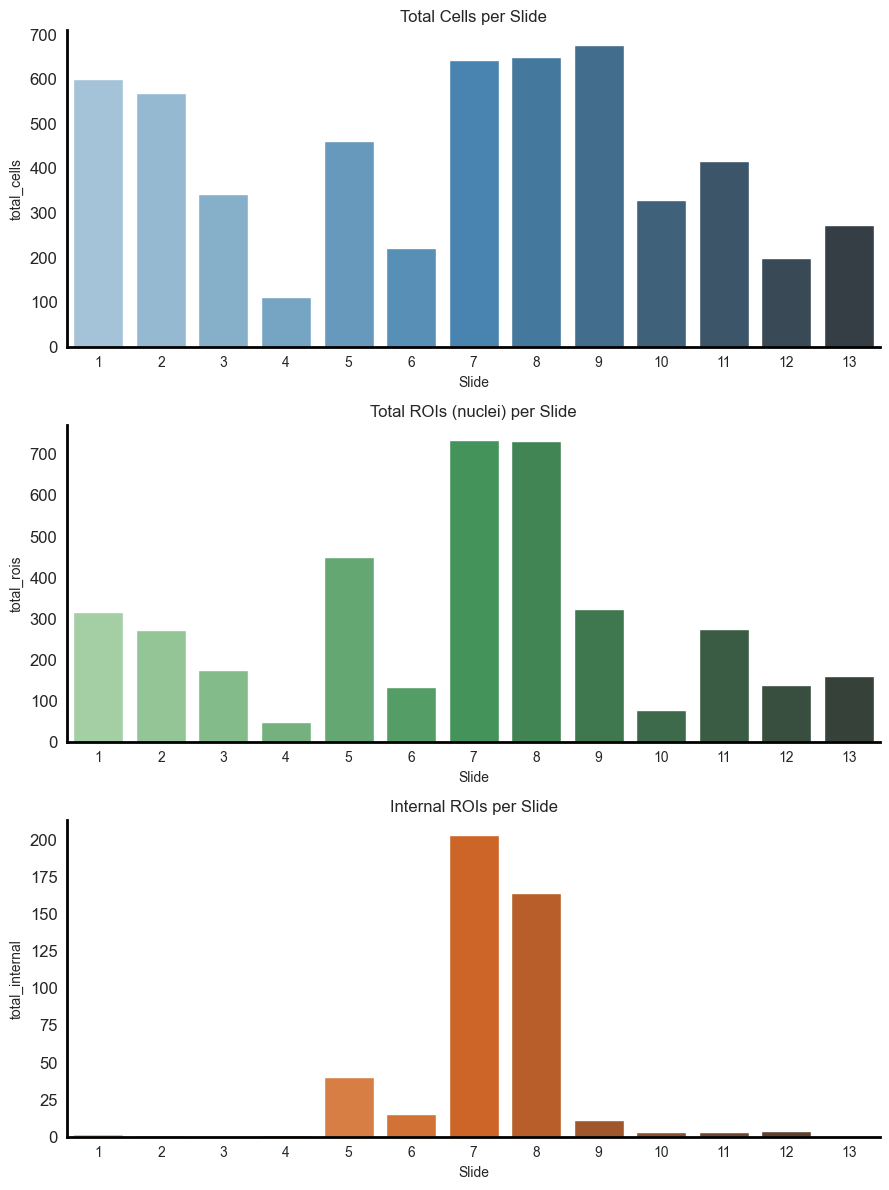

In [7]:
# 7) Visualization: Per-Slide Bar Charts
fig, axes = plt.subplots(3, 1, figsize=(9, 12))

metrics = [
    ('total_cells', 'Total Cells per Slide', 'Blues_d'),
    ('total_rois', 'Total ROIs (nuclei) per Slide', 'Greens_d'),
    ('total_internal', 'Internal ROIs per Slide', 'Oranges_d')
]

for ax, (metric, title, palette) in zip(axes, metrics):
    sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y=metric, ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlabel('Slide')
    style_axis(ax)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'per_slide_metrics.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'per_slide_metrics.png'}")
plt.show()

C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\281738866.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y=metric, ax=ax, palette=palette)
C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\281738866.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y=metric, ax=ax, palette=palette)
C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\281738866.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y=metric, ax=ax, palette=palette)


✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\per_group_metrics.png


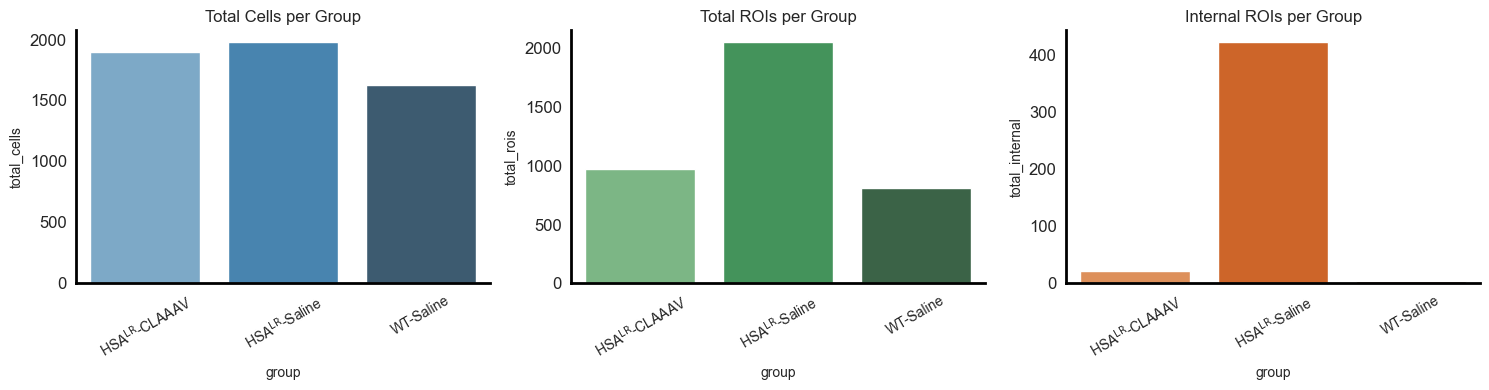

In [8]:
# 8) Visualization: Per-Group Bar Charts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = [
    ('total_cells', 'Total Cells per Group', 'Blues_d'),
    ('total_rois', 'Total ROIs per Group', 'Greens_d'),
    ('total_internal', 'Internal ROIs per Group', 'Oranges_d')
]

for ax, (metric, title, palette) in zip(axes, metrics):
    sns.barplot(data=group_agg, x='group', y=metric, ax=ax, palette=palette)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    style_axis(ax)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'per_group_metrics.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'per_group_metrics.png'}")
plt.show()

C:\Users\zyu\AppData\Local\Temp\ipykernel_15860\2147059585.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order,


✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\group_rois_total_internal_optimized.png


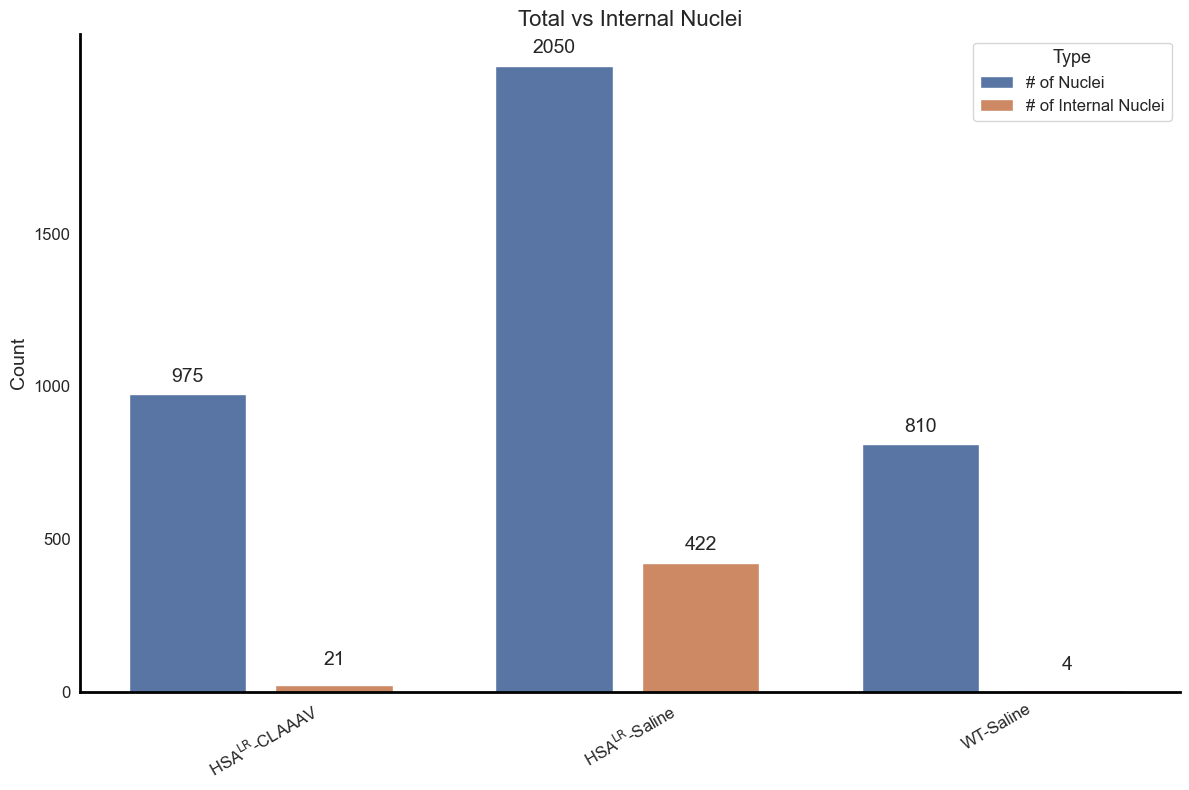

In [9]:
# 9) Combined Plot: Total vs Internal Nuclei per Group
plot_df = group_agg[['group', 'total_rois', 'total_internal']].melt(
    id_vars='group', 
    value_vars=['total_rois', 'total_internal'],
    var_name='type', 
    value_name='count'
)
plot_df['type'] = plot_df['type'].map({
    'total_rois': '# of Nuclei', 
    'total_internal': '# of Internal Nuclei'
})

fig, ax = plt.subplots(figsize=(12, 8))
order = group_agg['group'].tolist()

sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order, 
            palette=['#4C72B0', '#DD8452'], ci=None, ax=ax)

ax.set_title('Total vs Internal Nuclei', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', rotation=30, labelsize=12)

# Narrow bars
for p in ax.patches:
    p.set_width(p.get_width() * 0.8)
    p.set_x(p.get_x() + p.get_width() * 0.1)

# Y-axis settings
ymax = max(1600, plot_df['count'].max() * 1.05)
ax.set_ylim(0, ymax)
ax.set_yticks([0, 500, 1000, 1500])

# Add value labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        offset = 6 if height >= 50 else 12
        ax.annotate(f'{int(round(height))}', 
                    xy=(p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=14, 
                    xytext=(0, offset), textcoords='offset points', 
                    clip_on=False, zorder=10)

ax.legend(title='Type', fontsize=12, title_fontsize=13)
style_axis(ax)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'group_rois_total_internal_optimized.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'group_rois_total_internal_optimized.png'}")
plt.show()

✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\ratio_analysis_per_slide_optimized.png


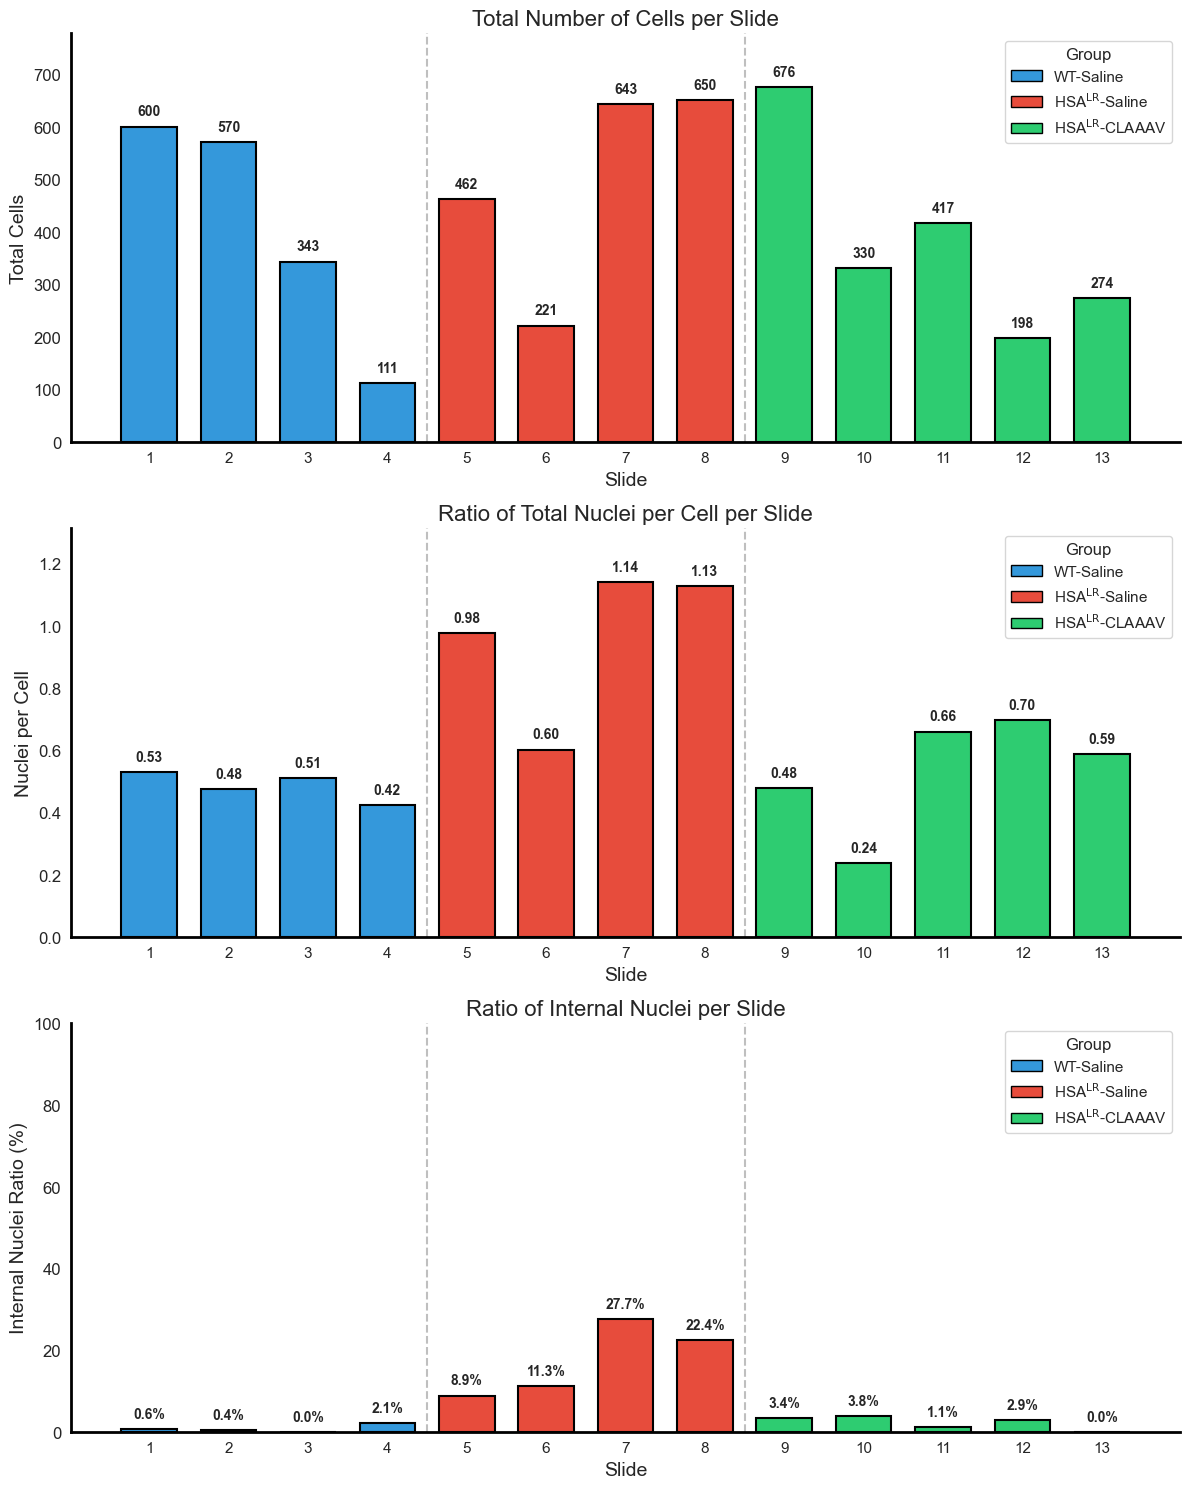


Summary Statistics by Group:

Total Cells:
                             sum   mean         std  min  max
group                                                        
HSA$^{\mathrm{LR}}$-CLAAAV  1895  379.0  184.282392  198  676
HSA$^{\mathrm{LR}}$-Saline  1976  494.0  201.734148  221  650
WT-Saline                   1624  406.0  227.688384  111  600

Nuclei per Cell:
                                mean       std       min       max
group                                                             
HSA$^{\mathrm{LR}}$-CLAAAV  0.531642  0.184994  0.236364  0.696970
HSA$^{\mathrm{LR}}$-Saline  0.961420  0.251073  0.601810  1.141524
WT-Saline                   0.484350  0.046168  0.423423  0.528333

Internal Ratio (%):
                                 mean       std      min        max
group                                                              
HSA$^{\mathrm{LR}}$-CLAAAV   2.248237  1.636280  0.00000   3.846154
HSA$^{\mathrm{LR}}$-Saline  17.552106  8.951759  8.86918  27.656676


In [10]:
# 10) Multi-Panel: Cells, Nuclei per Cell, and Internal Ratio by Slide
GROUP_ORDER = ['WT-Saline', r'HSA$^{\mathrm{LR}}$-Saline', r'HSA$^{\mathrm{LR}}$-CLAAAV']
GROUP_PALETTE = {
    'WT-Saline': '#3498db', 
    r'HSA$^{\mathrm{LR}}$-Saline': '#e74c3c', 
    r'HSA$^{\mathrm{LR}}$-CLAAAV': '#2ecc71'
}

# Sort slides by group order
slide_agg_sorted = slide_agg.copy()
slide_agg_sorted['group_order'] = slide_agg_sorted['group'].map({g: i for i, g in enumerate(GROUP_ORDER)})
slide_agg_sorted.sort_values(['group_order', 'slide'], inplace=True)

fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Subplot configurations
subplot_configs = [
    ('total_cells', 'Total Number of Cells per Slide', 'Total Cells', None),
    ('nuclei_per_cell', 'Ratio of Total Nuclei per Cell per Slide', 'Nuclei per Cell', 2),
    ('internal_ratio_pct', 'Ratio of Internal Nuclei per Slide', 'Internal Nuclei Ratio (%)', 1)
]

for ax, (metric, title, ylabel, val_fmt) in zip(axes, subplot_configs):
    # Create bars
    colors = [GROUP_PALETTE.get(g, '#95a5a6') for g in slide_agg_sorted['group']]
    bars = ax.bar(range(len(slide_agg_sorted)), slide_agg_sorted[metric], 
                   color=colors, edgecolor='black', linewidth=1.5, width=0.7)
    
    # Styling
    ax.set_xlabel('Slide', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(range(len(slide_agg_sorted)))
    ax.set_xticklabels(slide_agg_sorted['slide'].astype(int), fontsize=11)
    
    # Y-axis range
    if metric == 'internal_ratio_pct':
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ymax = 100
    else:
        ymax = slide_agg_sorted[metric].max() * 1.15
        ax.set_ylim(0, ymax)
    
    # Value labels
    for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
        value = row[metric]
        offset = ymax * 0.02
        if val_fmt is None:
            label = f"{int(value)}"
        else:
            label = f"{value:.{val_fmt}f}{'%' if metric == 'internal_ratio_pct' else ''}"
        ax.text(i, value + offset, label, ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # Group separators
    current_group = None
    for i, (idx, row) in enumerate(slide_agg_sorted.iterrows()):
        if row['group'] != current_group and i > 0:
            ax.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
        current_group = row['group']
    
    # Legend
    legend_elements = [Patch(facecolor=GROUP_PALETTE[g], edgecolor='black', label=g) 
                       for g in GROUP_ORDER if g in slide_agg_sorted['group'].values]
    ax.legend(handles=legend_elements, title='Group', fontsize=11, title_fontsize=12, loc='upper right')
    
    style_axis(ax)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'ratio_analysis_per_slide_optimized.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'ratio_analysis_per_slide_optimized.png'}")
plt.show()

# Summary statistics
print('\nSummary Statistics by Group:')
print('\nTotal Cells:')
print(slide_agg.groupby('group')['total_cells'].agg(['sum', 'mean', 'std', 'min', 'max']))
print('\nNuclei per Cell:')
print(slide_agg.groupby('group')['nuclei_per_cell'].agg(['mean', 'std', 'min', 'max']))
print('\nInternal Ratio (%):')
print(slide_agg.groupby('group')['internal_ratio_pct'].agg(['mean', 'std', 'min', 'max']))

✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\boxplot_nuclei_metrics_by_group_optimized.png


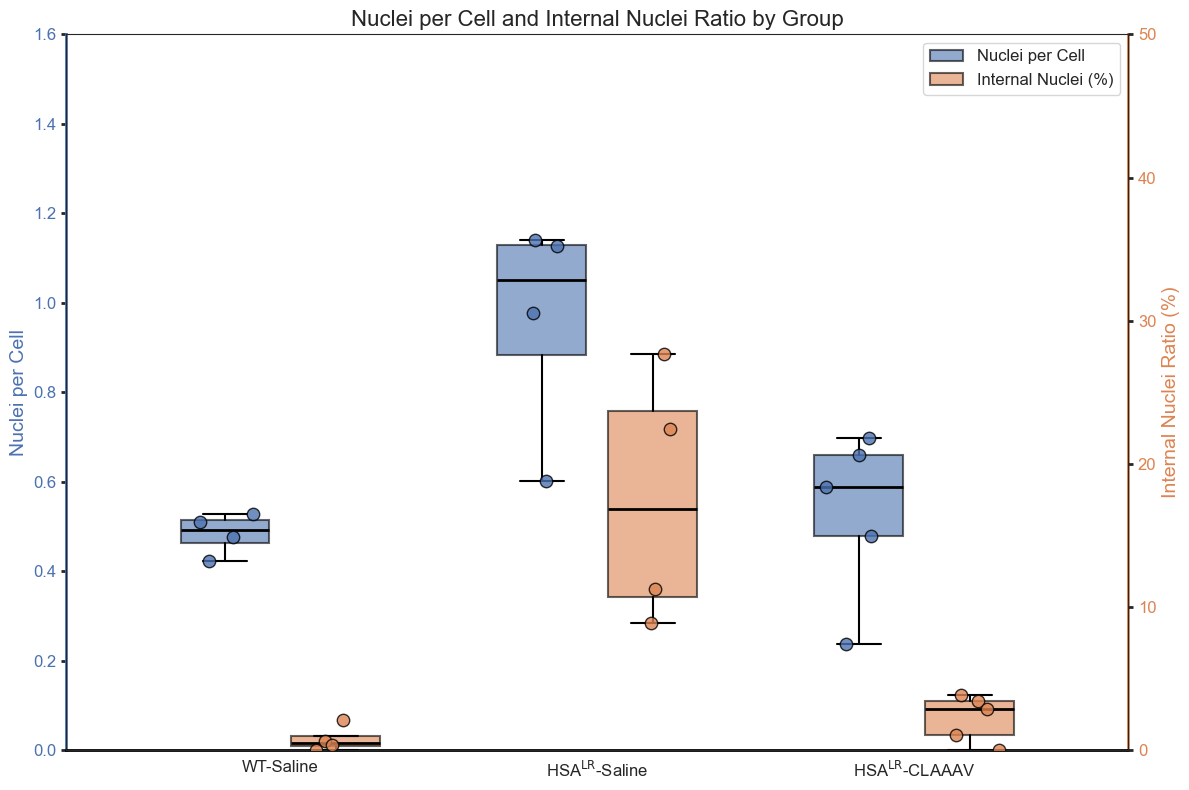

In [11]:
# 11) Box Plot: Nuclei Metrics by Group (Dual Y-Axes)
# Prepare data
plot_data = []
for _, row in slide_agg.iterrows():
    plot_data.extend([
        {'group': row['group'], 'metric': 'Nuclei per Cell', 'value': row['nuclei_per_cell']},
        {'group': row['group'], 'metric': 'Internal Nuclei (%)', 'value': row['internal_ratio_pct']}
    ])
plot_df_box = pd.DataFrame(plot_data)

# Create figure with dual axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax2 = ax1.twinx()

# Configuration
colors = {'Nuclei per Cell': '#4C72B0', 'Internal Nuclei (%)': '#DD8452'}
width = 0.35
x_positions = np.arange(len(GROUP_ORDER))

# Prepare grouped data
nuclei_per_cell_data = [plot_df_box[(plot_df_box['group'] == g) & 
                                    (plot_df_box['metric'] == 'Nuclei per Cell')]['value'].values 
                        for g in GROUP_ORDER]
internal_ratio_data = [plot_df_box[(plot_df_box['group'] == g) & 
                                   (plot_df_box['metric'] == 'Internal Nuclei (%)')]['value'].values 
                       for g in GROUP_ORDER]

# Box plots
box_props = dict(linewidth=1.5, edgecolor='black')
whisker_props = dict(linewidth=1.5, color='black')
median_props = dict(linewidth=2, color='black')

bp1 = ax1.boxplot(nuclei_per_cell_data, positions=x_positions - width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False, 
                  boxprops={**box_props, 'facecolor': colors['Nuclei per Cell'], 'alpha': 0.6},
                  whiskerprops=whisker_props, capprops=whisker_props, medianprops=median_props)

bp2 = ax2.boxplot(internal_ratio_data, positions=x_positions + width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False,
                  boxprops={**box_props, 'facecolor': colors['Internal Nuclei (%)'], 'alpha': 0.6},
                  whiskerprops=whisker_props, capprops=whisker_props, medianprops=median_props)

# Add scatter points
for i, group in enumerate(GROUP_ORDER):
    # Nuclei per cell
    npc_vals = plot_df_box[(plot_df_box['group'] == group) & 
                           (plot_df_box['metric'] == 'Nuclei per Cell')]['value'].values
    x_npc = np.random.normal(x_positions[i] - width/2, 0.04, size=len(npc_vals))
    ax1.scatter(x_npc, npc_vals, alpha=0.8, s=80, color=colors['Nuclei per Cell'], 
               edgecolors='black', linewidth=1, zorder=3)
    
    # Internal nuclei ratio
    int_vals = plot_df_box[(plot_df_box['group'] == group) & 
                           (plot_df_box['metric'] == 'Internal Nuclei (%)')]['value'].values
    x_int = np.random.normal(x_positions[i] + width/2, 0.04, size=len(int_vals))
    ax2.scatter(x_int, int_vals, alpha=0.8, s=80, color=colors['Internal Nuclei (%)'], 
               edgecolors='black', linewidth=1, zorder=3)

# Styling
ax1.set_xticks(x_positions)
ax1.set_xticklabels(GROUP_ORDER, fontsize=12)
ax1.set_ylabel('Nuclei per Cell', fontsize=14, color=colors['Nuclei per Cell'])
ax2.set_ylabel('Internal Nuclei Ratio (%)', fontsize=14, color=colors['Internal Nuclei (%)'])
ax1.set_title('Nuclei per Cell and Internal Nuclei Ratio by Group', fontsize=16)
ax1.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Nuclei per Cell'])
ax2.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Internal Nuclei (%)'])

# Y-axis ranges
ax1.set_ylim(0, max(plot_df_box[plot_df_box['metric'] == 'Nuclei per Cell']['value'].max() * 1.15, 1.6))
ax2.set_ylim(0, 50)

# Spines
ax1.spines['left'].set_linewidth(2)
ax1.spines['left'].set_color(colors['Nuclei per Cell'])
ax1.spines['right'].set_linewidth(2)
ax1.spines['right'].set_color(colors['Internal Nuclei (%)'])
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_visible(False)

# Legend
legend_elements = [
    mpatches.Patch(facecolor=colors['Nuclei per Cell'], alpha=0.6, 
                   edgecolor='black', linewidth=1.5, label='Nuclei per Cell'),
    mpatches.Patch(facecolor=colors['Internal Nuclei (%)'], alpha=0.6, 
                   edgecolor='black', linewidth=1.5, label='Internal Nuclei (%)')
]
ax1.legend(handles=legend_elements, fontsize=12, title_fontsize=13, loc='upper right')

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'boxplot_nuclei_metrics_by_group_optimized.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'boxplot_nuclei_metrics_by_group_optimized.png'}")
plt.show()

✓ Saved: S:\micro\ts2625\eh2888\lem\HEImages_0123\quantification\roi_analysis_results\boxplot_nuclei_metrics_by_group_all_measurements.png


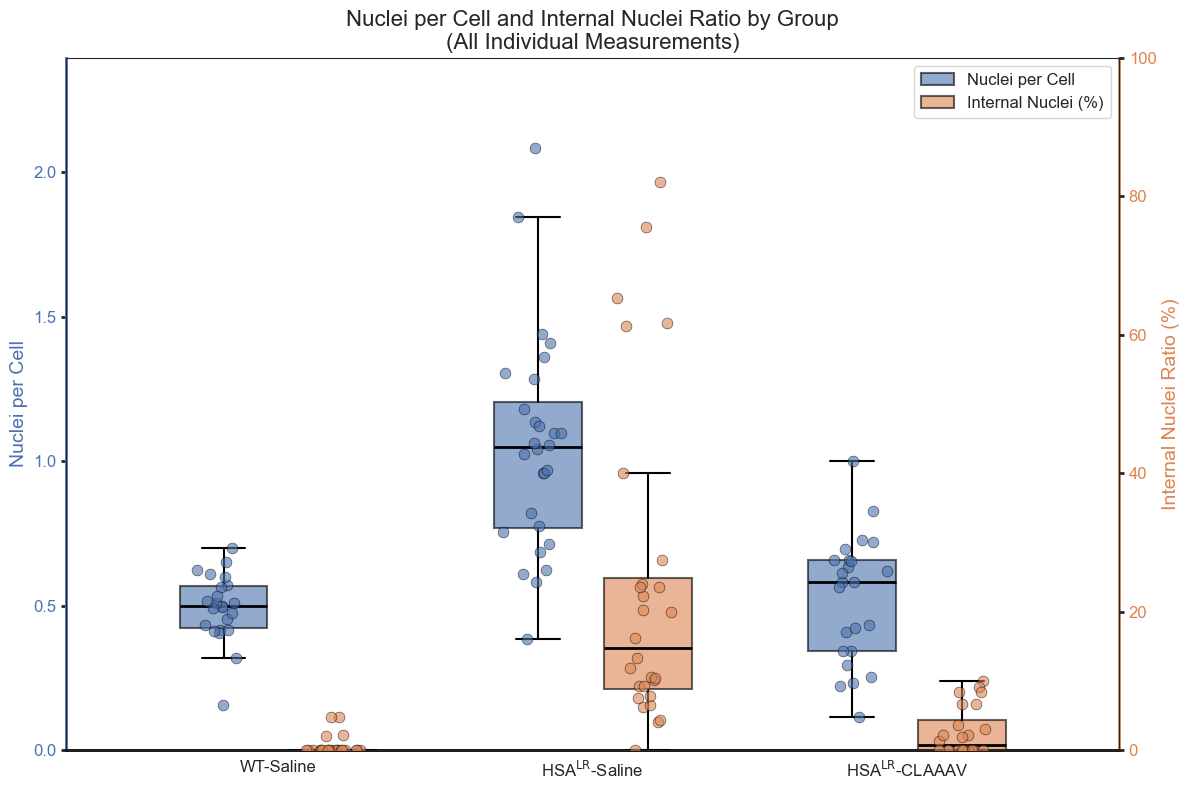


Summary Statistics by Group (Individual Measurements):

WT-Saline: 23 measurements
  Nuclei per Cell - Mean: 0.494, Std: 0.116
  Internal Nuclei (%) - Mean: 0.60, Std: 1.45

HSA$^{\mathrm{LR}}$-Saline: 28 measurements
  Nuclei per Cell - Mean: 1.050, Std: 0.373
  Internal Nuclei (%) - Mean: 24.09, Std: 23.31

HSA$^{\mathrm{LR}}$-CLAAAV: 24 measurements
  Nuclei per Cell - Mean: 0.526, Std: 0.217
  Internal Nuclei (%) - Mean: 2.65, Std: 3.49


In [13]:
# 12) Box Plot: Nuclei Metrics by Group (Per Individual Measurement)
# Calculate ratios for each individual measurement (row in summary_df)
summary_df['internal_ratio_pct'] = (summary_df['n_internal'] / summary_df['num_rois'] * 100).fillna(0)
summary_df['nuclei_per_cell'] = (summary_df['num_rois'] / summary_df['num_cells']).fillna(0)

# Prepare data for plotting - each row is one measurement
plot_data_measurements = []
for _, row in summary_df.iterrows():
    plot_data_measurements.extend([
        {'group': row['group'], 'metric': 'Nuclei per Cell', 'value': row['nuclei_per_cell']},
        {'group': row['group'], 'metric': 'Internal Nuclei (%)', 'value': row['internal_ratio_pct']}
    ])
plot_df_measurements = pd.DataFrame(plot_data_measurements)

# Create figure with dual axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax2 = ax1.twinx()

# Configuration
colors = {'Nuclei per Cell': '#4C72B0', 'Internal Nuclei (%)': '#DD8452'}
width = 0.35
x_positions = np.arange(len(GROUP_ORDER))

# Prepare grouped data by experimental group (all measurements per group)
nuclei_per_cell_data_measurements = [
    plot_df_measurements[(plot_df_measurements['group'] == g) & 
                        (plot_df_measurements['metric'] == 'Nuclei per Cell')]['value'].values 
    for g in GROUP_ORDER
]
internal_ratio_data_measurements = [
    plot_df_measurements[(plot_df_measurements['group'] == g) & 
                        (plot_df_measurements['metric'] == 'Internal Nuclei (%)')]['value'].values 
    for g in GROUP_ORDER
]

# Box plots
box_props = dict(linewidth=1.5, edgecolor='black')
whisker_props = dict(linewidth=1.5, color='black')
median_props = dict(linewidth=2, color='black')

bp1 = ax1.boxplot(nuclei_per_cell_data_measurements, positions=x_positions - width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False, 
                  boxprops={**box_props, 'facecolor': colors['Nuclei per Cell'], 'alpha': 0.6},
                  whiskerprops=whisker_props, capprops=whisker_props, medianprops=median_props)

bp2 = ax2.boxplot(internal_ratio_data_measurements, positions=x_positions + width/2, widths=width*0.8,
                  patch_artist=True, showfliers=False,
                  boxprops={**box_props, 'facecolor': colors['Internal Nuclei (%)'], 'alpha': 0.6},
                  whiskerprops=whisker_props, capprops=whisker_props, medianprops=median_props)

# Add scatter points for individual measurements
for i, group in enumerate(GROUP_ORDER):
    # Nuclei per cell - all measurements from this group
    npc_vals = plot_df_measurements[(plot_df_measurements['group'] == group) & 
                                   (plot_df_measurements['metric'] == 'Nuclei per Cell')]['value'].values
    if len(npc_vals) > 0:
        x_npc = np.random.normal(x_positions[i] - width/2, 0.04, size=len(npc_vals))
        ax1.scatter(x_npc, npc_vals, alpha=0.6, s=60, color=colors['Nuclei per Cell'], 
                   edgecolors='black', linewidth=0.5, zorder=3)
    
    # Internal nuclei ratio - all measurements from this group
    int_vals = plot_df_measurements[(plot_df_measurements['group'] == group) & 
                                   (plot_df_measurements['metric'] == 'Internal Nuclei (%)')]['value'].values
    if len(int_vals) > 0:
        x_int = np.random.normal(x_positions[i] + width/2, 0.04, size=len(int_vals))
        ax2.scatter(x_int, int_vals, alpha=0.6, s=60, color=colors['Internal Nuclei (%)'], 
                   edgecolors='black', linewidth=0.5, zorder=3)

# Styling
ax1.set_xticks(x_positions)
ax1.set_xticklabels(GROUP_ORDER, fontsize=12)
ax1.set_ylabel('Nuclei per Cell', fontsize=14, color=colors['Nuclei per Cell'])
ax2.set_ylabel('Internal Nuclei Ratio (%)', fontsize=14, color=colors['Internal Nuclei (%)'])
ax1.set_title('Nuclei per Cell and Internal Nuclei Ratio by Group\n(All Individual Measurements)', fontsize=16)
ax1.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Nuclei per Cell'])
ax2.tick_params(axis='y', labelsize=12, width=2, labelcolor=colors['Internal Nuclei (%)'])

# Y-axis ranges
max_npc = plot_df_measurements[plot_df_measurements['metric'] == 'Nuclei per Cell']['value'].max()
ax1.set_ylim(0, max(max_npc * 1.15, 1.6))
ax2.set_ylim(0, 100)

# Spines
ax1.spines['left'].set_linewidth(2)
ax1.spines['left'].set_color(colors['Nuclei per Cell'])
ax1.spines['right'].set_linewidth(2)
ax1.spines['right'].set_color(colors['Internal Nuclei (%)'])
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_visible(False)

# Legend
legend_elements = [
    mpatches.Patch(facecolor=colors['Nuclei per Cell'], alpha=0.6, 
                   edgecolor='black', linewidth=1.5, label='Nuclei per Cell'),
    mpatches.Patch(facecolor=colors['Internal Nuclei (%)'], alpha=0.6, 
                   edgecolor='black', linewidth=1.5, label='Internal Nuclei (%)')
]
ax1.legend(handles=legend_elements, fontsize=12, title_fontsize=13, loc='upper right')

plt.tight_layout()
plt.savefig(RESULTS_FOLDER / 'boxplot_nuclei_metrics_by_group_all_measurements.png', dpi=DPI, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_FOLDER / 'boxplot_nuclei_metrics_by_group_all_measurements.png'}")
plt.show()

# Summary statistics by group showing all individual measurements
print('\nSummary Statistics by Group (Individual Measurements):')
for group in GROUP_ORDER:
    group_data = summary_df[summary_df['group'] == group]
    n_measurements = len(group_data)
    print(f"\n{group}: {n_measurements} measurements")
    print(f"  Nuclei per Cell - Mean: {group_data['nuclei_per_cell'].mean():.3f}, Std: {group_data['nuclei_per_cell'].std():.3f}")
    print(f"  Internal Nuclei (%) - Mean: {group_data['internal_ratio_pct'].mean():.2f}, Std: {group_data['internal_ratio_pct'].std():.2f}")